# Multi-Asset Option Pricing : Three Different Examples

### 1. Import necessary packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

### 2. Simulation of  $\{\tilde S_{i}\}_{i=0, \ldots, N}$ and $\{W_{t_i}\}_{i=0, \ldots, N}$

In [2]:
# Final time
T = 1.

# Spatial dimensions
dim = 100

# Number of intervals in time
N = 40

# Derive time step size and t_space
dt = T/N
t_space = np.linspace(0, T, N + 1)

# Point of interest at t=0
s = np.zeros(dim)

# Diffusive and drift term is assumed to be constant
sigma = 0.2
mu = 0.06

Next, we define a function to draw multiple sample paths of $\{\tilde X_{i}\}_{i=0, \ldots, N}$ and the corresponding increments of the Brownian motions $\{W_{t_i}\}_{i=0, \ldots, N}$ according to

$$
\tilde S_{{n+1}} = \tilde S_{n}
+ \mu(t_n, \tilde S_{n}) \, (t_{n+1} - t_n)
+ \sigma(t_n, \tilde S_{n}) \, ( W_{t_{n+1}} - W_{t_n}), \qquad \tilde S_0 = s,
$$

for the particular case $\mu(t,S_t) = \mu$ and $\sigma(t,S_t) \equiv \sigma I_{d \times d}$.

In [3]:
def draw_X_and_dW(num_sample, s):
    """ Function to draw num_sample many paths of the stochastic process X
    and the corresponding increments of simulated Brownian motions dW. """

    dim = s.shape[0]

    # Draw all increments of W
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(num_sample, dim, N)).astype(DTYPE)

    # Initialize the X array
    S = np.zeros((num_sample, dim, N+1), dtype=DTYPE)

    # Set starting point to x for each draw
    S[:, :, 0] = np.ones([num_sample, dim]) * np.ones(dim) * 100

    for i in range(N):
        # The Euler-Maruyama Scheme
        S[:, :, i+1] = (1 + mu * dt) * S[:, :, i] + sigma * S[:, :, i] * dW[:, :, i]
    # Return simulated paths as well as increments of Brownian motion
    return S, dW

Finally, we may test the function and draw 40 samples of the process $\{\tilde S_{i}\}_{i=0,\ldots,N}$.

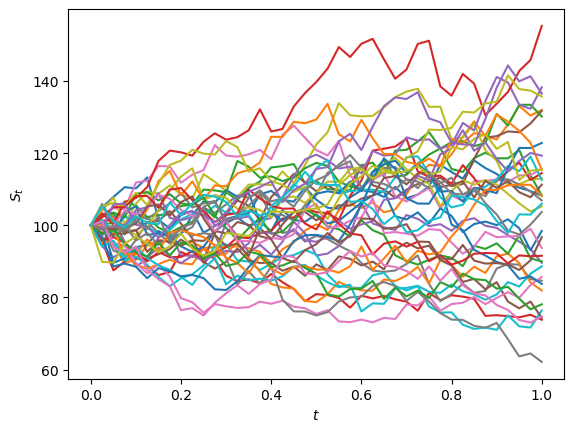

In [5]:
num_sample=40

# Draw 10 sample paths
S,dW = draw_X_and_dW(num_sample, np.zeros(1))

# Plot these paths
fig,ax = plt.subplots(1)
for i in range(num_sample):
    ax.plot(t_space,S[i,0,:])
ax.set_xlabel('$t$')
ax.set_ylabel('$S_t$');

### 3. Simulation of $\{\tilde C_{i}(t_{i},S_{i})\}$


These networks have the following structure:

    Input -> BN -> (Dense -> BN -> ReLU) -> (Dense -> BN -> ReLU) -> Dense -> BN -> Output
    
Here, `BN` denotes Batch Normalization, `Dense` a fully connected layer without bias term and activation, and `ReLU` the componentwise application of the  ReLU activation function $\mathrm{relu}(x) = \max \{0,x\}$.

We define the complete network as one class derived from `tf.keras.model`.


In [12]:
class BSDEModel(tf.keras.Model):
    def __init__(self, **kwargs):

        # Call the initializer of tf.keras.Model
        super().__init__(**kwargs)

        # Initialize the value u(0, x) randomly (uniform distribution)
        c0 = np.random.uniform(0., 0., size=(1)).astype(DTYPE)
        self.c0 = tf.Variable(c0)

        # Initialize the gradient nabla u(0, x) randomly (uniform distribution)
        gradc0 = np.random.uniform(-1e-1, 1e-1, size=(1, dim)).astype(DTYPE)
        self.gradc0 = tf.Variable(gradc0)

        # Create template of dense layer without bias and activation
        _dense = lambda dim: tf.keras.layers.Dense(
            units=dim,
            activation=None,
            use_bias=False)

        # Create template of batch normalization (BN) layer
        _bn = lambda : tf.keras.layers.BatchNormalization(
            momentum=.99,
            epsilon=1e-6,
            beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1),
            gamma_initializer=tf.random_uniform_initializer(0.1, 0.5))


        # Initialize a list of networks approximating the gradient of u(t, x) at t_i
        self.gradci = []

        # Loop over number of time steps
        for _ in range(N - 1):

            # Batch normalization on dim-dimensional input
            this_grad = tf.keras.Sequential()
            this_grad.add(tf.keras.layers.Input(dim))
            this_grad.add(_bn())

            # Two hidden layers of type (Dense -> Batch Normalization -> ReLU)
            for _ in range(2):
                this_grad.add(_dense(dim+10))
                this_grad.add(_bn())
                this_grad.add(tf.keras.layers.ReLU())

            # Dense layer followed by batch normalization for output
            this_grad.add(_dense(dim))
            this_grad.add(_bn())
            self.gradci.append(this_grad)

Next, we define a function to draw multiple realizations of $\tilde C_{N} \approx C(T, S_T)$ by sweeping through the network.
The intermediate values $\{\tilde C(t_{i},S_{i})\}_{i=0,\ldots,N-1}$ are not stored.

In [13]:
def simulate_Y(inp, model, fun_f):
    """ This function performs the forward sweep through the network.
    """

    S, dW = inp
    num_sample = S.shape[0]


    e_num_sample = tf.ones(shape=[num_sample, 1], dtype=DTYPE)

    # Value approximation at t0
    y = e_num_sample * model.c0

    # Gradient approximation at t0
    z = e_num_sample * model.gradc0

    for i in range(N-1):
        t = t_space[i]

        # Determine terms in right-hand side of Y-update at t_i
        side1 = - fun_f(t, S[:, :, i], y, z) * dt
        side2 = tf.reduce_sum(z * dW[:, :, i], axis=1, keepdims=True)

        # Compute new value approximations at t_{i+1}
        y = y + side1 + side2
        z = model.gradci[i](S[:, :, i + 1]) / dim


    # Final step
    side1 = - fun_f(t_space[N-1], S[:, :, N-1], y, z) * dt
    side2 = tf.reduce_sum(z * dW[:, :, N-1], axis=1, keepdims=True)
    y = y + side1 + side2

    return y

### 4. Evaluation of loss function

In the next step, we define the loss function, i.e., the function to be minimized.
Since $\tilde C(T,S_{T})$ approximates $C(T, S_T) = g(S_T)$ we minimize the mean squared error (MSE) between $\tilde C(T,S_{T})$ and $g(\tilde S_N)$.

In [14]:
def loss_fn(inp, model, fun_f, fun_g):
    """ This function computes the mean-squarred error of the difference of Y_T and g(X_T)
        inp - (X, dW)
        model - model of neural network
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """
    S, _ = inp

    # Compute value estimates
    y_pred = simulate_Y(inp, model, fun_f)

    # Evaluate g(X_T)
    y = fun_g(S[:, :, -1])

    # Compute mean squared error (MSE)
    y_diff = y-y_pred
    loss = tf.reduce_mean(tf.square(y_diff))

    return loss

### 5. Computation of the gradient with respect to the network parameters $\theta$


The next step uses the automatic differentiation functionality of TensorFlow to compute the gradient of the loss function with respect to the unknowns $\theta$, called `trainable_variables` in TensorFlow.

In [15]:
@tf.function
def compute_grad(inp, model, fun_f, fun_g):
    """ This function computes the gradient of the loss function with respect to
    the trainable variables theta.
        inp - (S, dW)
        model - model of neural network
        fun_f - function handle for cost function f
        fun_g - function handle for terminal condition g
    """

    with tf.GradientTape() as tape:
        loss = loss_fn(inp, model, fun_f, fun_g)

    grad = tape.gradient(loss, model.trainable_variables)

    return loss, grad

# Example 1: Classical Multi-Asset Option Pricing (Black-Scholes PDE)

In [16]:
# Define cost function f, remember that z approximates \sigma^T \nabla u
rate = 0.06   # interest rate R
def fun_f(t, s, y, z):
    return - rate * y

# Set terminal value function g
def fun_g(x):
    return tf.reduce_min(x, 1, keepdims=True)

# Set learning rate
lr = 8e-3
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()
y_star = 59.4

# Initialize list containing history of losses
history = []

In [17]:
t0 = time()

num_epochs = 30000

# Initialize header of output
print('  Iter        Loss        C   L1_rel    L1_abs   |   Time  Stepsize')

for i in range(num_epochs):

    # Each epoch we draw a batch of 64 random paths
    S, dW = draw_X_and_dW(64, s)

    # Compute the loss as well as the gradient
    loss, grad = compute_grad((S, dW), model, fun_f, fun_g)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

    # Get current Y_0 \approx C(0,s)
    y = model.c0.numpy()[0]

    currtime = time() - t0
    l1abs = np.abs(y - y_star)
    l1rel = l1abs / y_star

    hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr)
    history.append(hentry)
    if i%100 == 0:
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))

  Iter        Loss        C   L1_rel    L1_abs   |   Time  Stepsize
    0    3856.3459   0.0080   0.9999   61.9920   |   29.3  8.00e-03
  100    4075.7925   0.8063   0.9870   61.1937   |  242.0  8.00e-03
  200    3522.8477   1.5988   0.9742   60.4012   |  445.8  8.00e-03
  300    3786.3721   2.3863   0.9615   59.6137   |  631.7  8.00e-03
  400    3533.5342   3.1690   0.9489   58.8310   |  817.3  8.00e-03
  500    3474.2312   3.9478   0.9363   58.0522   | 1008.3  8.00e-03
  600    3342.2800   4.7198   0.9239   57.2802   | 1205.3  8.00e-03
  700    3332.5867   5.4868   0.9115   56.5132   | 1407.0  8.00e-03
  800    3252.2363   6.2515   0.8992   55.7485   | 1600.2  8.00e-03
  900    3082.1069   7.0120   0.8869   54.9880   | 1792.9  8.00e-03
 1000    3043.0061   7.7685   0.8747   54.2315   | 1965.8  8.00e-03
 1100    2959.6030   8.5199   0.8626   53.4801   | 2143.4  8.00e-03
 1200    2742.7349   9.2689   0.8505   52.7311   | 2321.0  8.00e-03
 1300    2845.9951  10.0121   0.8385   51.9879  

KeyboardInterrupt: 

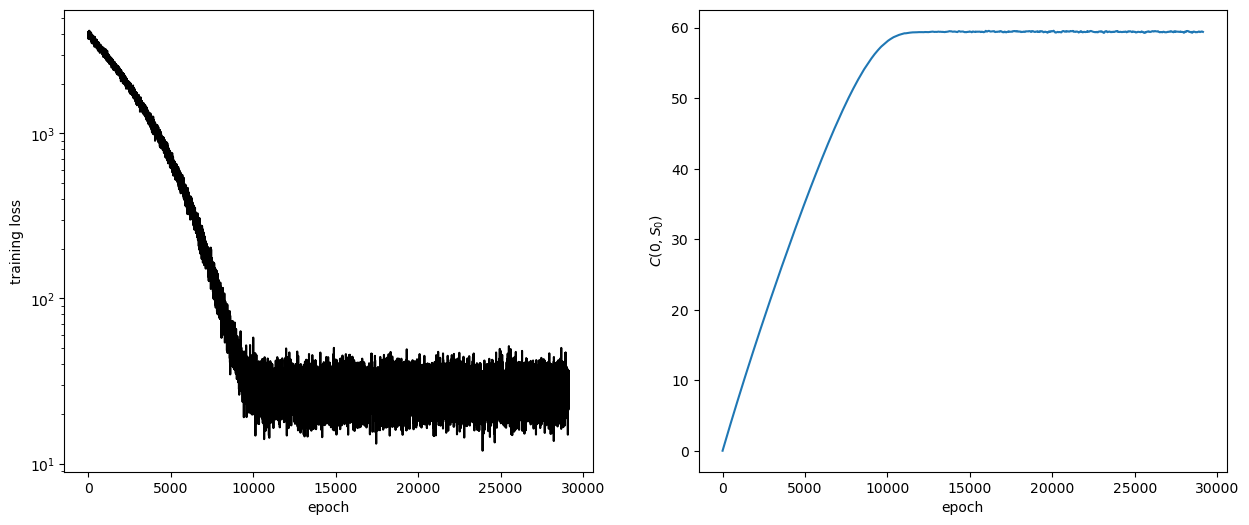

In [18]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
xrange = range(len(history))
ax[0].semilogy(xrange, [e[1] for e in history],'k-')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training loss')
ax[1].plot(xrange, [e[2] for e in history])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('$C(0,S_{0})$');

# Example 2: Pricing Multi-Asset Option with a Risk of Default

In [19]:
# Define cost function f, remember that z approximates \sigma^T \nabla u
rate = 0.06   # interest rate R
delta = 2.0 / 3 #the fraction
gammah = 0.5
gammal = 0.05
vh = 40.0
vl = 80.0
slope = (gammah - gammal) / (vh - vl)
def fun_f(t, x, y, z):
    piecewise_linear = tf.nn.relu(tf.nn.relu(y - vh) * slope + gammah - gammal) + gammal
    return (-(1 - delta) * piecewise_linear - rate) * y

# Set terminal value function g
def fun_g(x):
    return tf.reduce_min(x, 1, keepdims=True)

# Set learning rate
lr = 8e-3
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()
y_star = 53.9

# Initialize list containing history of losses
history = []

Next, we train the model for multiple epochs using batches of size 64.

In [20]:
t0 = time()

num_epochs = 30000

# Initialize header of output
print('  Iter        Loss        C   L1_rel    L1_abs   |   Time  Stepsize')

for i in range(num_epochs):

    # Each epoch we draw a batch of 64 random paths
    S, dW = draw_X_and_dW(64, s)

    # Compute the loss as well as the gradient
    loss, grad = compute_grad((S, dW), model, fun_f, fun_g)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

    # Get current Y_0 \approx u(0,x)
    y = model.c0.numpy()[0]

    currtime = time() - t0
    l1abs = np.abs(y - y_star)
    l1rel = l1abs / y_star

    hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr)
    history.append(hentry)
    if i%100 == 0:
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))

  Iter        Loss        C   L1_rel    L1_abs   |   Time  Stepsize
    0    4270.8569   0.0080   0.9999   57.2920   |   34.2  8.00e-03
  100    3959.8774   0.8058   0.9859   56.4942   |  263.2  8.00e-03
  200    3739.8254   1.5984   0.9721   55.7016   |  476.2  8.00e-03
  300    3588.9102   2.3848   0.9584   54.9152   |  663.8  8.00e-03
  400    3514.6001   3.1645   0.9448   54.1355   |  912.0  8.00e-03
  500    3473.8120   3.9393   0.9313   53.3607   | 1150.1  8.00e-03
  600    3261.7261   4.7080   0.9178   52.5920   | 1379.4  8.00e-03
  700    3146.1797   5.4697   0.9045   51.8303   | 1551.0  8.00e-03
  800    2994.0227   6.2262   0.8913   51.0738   | 1724.5  8.00e-03
  900    3137.5154   6.9775   0.8782   50.3225   | 1896.0  8.00e-03
 1000    2867.5737   7.7241   0.8652   49.5759   | 2126.3  8.00e-03
 1100    2888.2402   8.4658   0.8523   48.8342   | 2370.3  8.00e-03
 1200    2623.8528   9.2030   0.8394   48.0970   | 2617.3  8.00e-03
 1300    2678.7964   9.9363   0.8266   47.3637  

Plot training history and evolution of approximation of $C(0, S_{0})$.

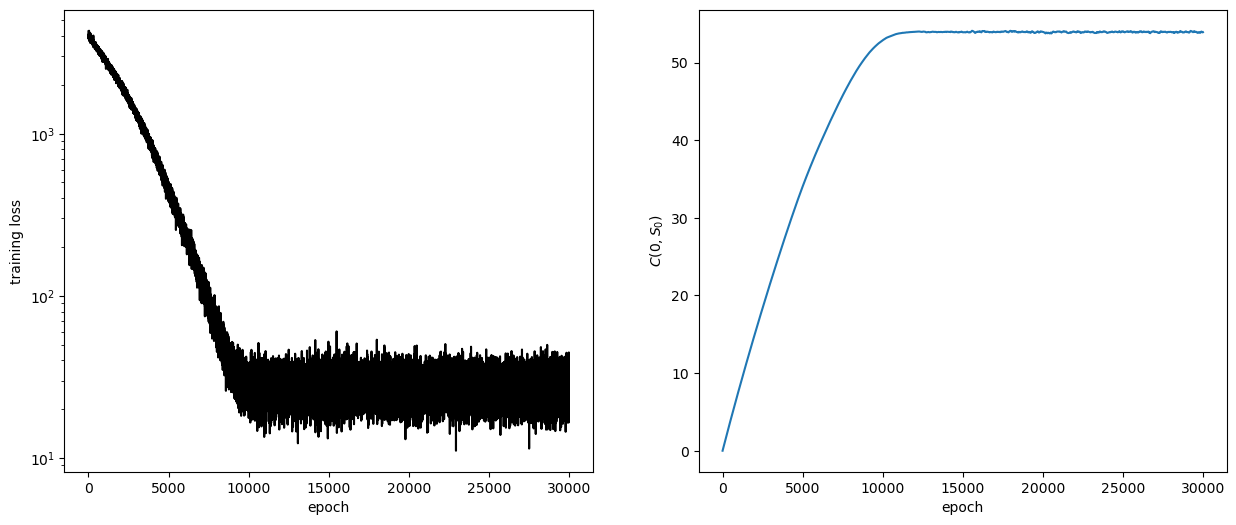

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
xrange = range(len(history))
ax[0].semilogy(xrange, [e[1] for e in history],'k-')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training loss')
ax[1].plot(xrange, [e[2] for e in history])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('$C(0,S_{0})$');

# Example 03 : Pricing Multi-Asset Option with Different Interest Rates

In [ ]:
# Define cost function f, remember that z approximates \sigma^T \nabla u
rl = 0.04  # interest rate for lending
rb = 0.06  # interest rate for borrowing
sigma = 0.2
mu = 0.06
alpha = 1.0 / dim

def fun_f(t, x, y, z):
    temp = tf.reduce_sum(z, 1, keepdims = True) / sigma
    return -rl * y - (mu - rl) * temp + ((rb -rl) * tf.maximum(temp - y, 0))
# Set terminal value function g
def fun_g(x):
    temp = tf.reduce_max(x, 1, keepdims = True)
    return tf.maximum(temp - 120, 0) - 2*tf.maximum(temp - 150, 0)

# Set learning rate
lr = 8e-3
# Choose optimizer for gradient descent step
optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8)

# Initialize neural network architecture
model = BSDEModel()
y_star = 7.166

# Initialize list containing history of losses
history = []

In [ ]:
t0 = time()

num_epochs = 30000

# Initialize header of output
print('  Iter        Loss        C   L1_rel    L1_abs   |   Time  Stepsize')

for i in range(num_epochs):

    # Each epoch we draw a batch of 64 random paths
    S, dW = draw_X_and_dW(64, s)

    # Compute the loss as well as the gradient
    loss, grad = compute_grad((S, dW), model, fun_f, fun_g)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

    # Get current Y_0 \approx u(0,x)
    y = model.c0.numpy()[0]

    currtime = time() - t0
    l1abs = np.abs(y - y_star)
    l1rel = l1abs / y_star

    hentry = (i, loss.numpy(), y, l1rel, l1abs, currtime, lr)
    history.append(hentry)
    if i%100 == 0:
        print('{:5d} {:12.4f} {:8.4f} {:8.4f}  {:8.4f}   | {:6.1f}  {:6.2e}'.format(*hentry))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
xrange = range(len(history))
ax[0].semilogy(xrange, [e[1] for e in history],'k-')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('training loss')
ax[1].plot(xrange, [e[2] for e in history])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('$C(0,S_{0})$');